<a href="https://colab.research.google.com/github/andreidore/recipes/blob/main/recipies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 9.9 MB/s 
     |████████████████████████████████| 3.3 MB 52.8 MB/s 
     |████████████████████████████████| 56 kB 5.4 MB/s 
     |████████████████████████████████| 895 kB 78.1 MB/s 
     |████████████████████████████████| 596 kB 83.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tqdm import tqdm
from transformers import AutoTokenizer, TFBertModel, BertConfig

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))



tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [4]:
df=pd.read_csv("recipes.csv",sep=";")

In [5]:
df.head()

,Recipe Name,Review Count,Recipe Photo,Author,Prepare Time,Cook Time,Total Time,Ingredients,Directions,RecipeID
0,Golden Crescent Rolls Recipe,304,https://images.media-allrecipes.com/userphotos...,Mike A.,25 m,15 m,3 h 10 m,"yeast,water,white sugar,salt,egg,butter,flour,...","Dissolve yeast in warm water.**Stir in sugar, ...",7000
1,Poppy Seed Bread with Glaze Recipe,137,https://images.media-allrecipes.com/userphotos...,Christina Jun,15 m,1 h,1 h 20 m,"flour,salt,baking powder,poppy,butter,vegetabl...",'Preheat oven to 350 degrees F (175 degrees C)...,7001
2,Applesauce Bread I Recipe,124,https://images.media-allrecipes.com/userphotos...,GAF55,10 m,1 h 20 m,1 h 30 m,"flour,egg,white sugar,vegetable oil,applesauce...",Preheat oven to 350 degrees F (175 degrees C)....,7003
3,Apple Raisin Bread Recipe,39,https://images.media-allrecipes.com/userphotos...,Helen Hanson,15 m,1 h,1 h 15 m,"flour,baking powder,baking soda,salt,cinnamon,...",Preheat oven to 350 degrees F (175 degrees C)....,7006
4,Buttermilk Oatmeal Bread Recipe,41,https://images.media-allrecipes.com/userphotos...,Helen Hanson,10 m,1 h,1 h 40 m,"oat,buttermilk,vegetable oil,egg,brown sugar,f...",Mix oats with buttermilk. Let stand for 1/2 h...,7007


In [6]:
df=df[["Ingredients","Directions"]]
df.head()

,Ingredients,Directions
0,"yeast,water,white sugar,salt,egg,butter,flour,...","Dissolve yeast in warm water.**Stir in sugar, ..."
1,"flour,salt,baking powder,poppy,butter,vegetabl...",'Preheat oven to 350 degrees F (175 degrees C)...
2,"flour,egg,white sugar,vegetable oil,applesauce...",Preheat oven to 350 degrees F (175 degrees C)....
3,"flour,baking powder,baking soda,salt,cinnamon,...",Preheat oven to 350 degrees F (175 degrees C)....
4,"oat,buttermilk,vegetable oil,egg,brown sugar,f...",Mix oats with buttermilk. Let stand for 1/2 h...


In [7]:
df.shape

(12351, 2)

In [8]:
df.dropna(inplace=True)
df.drop_duplicates(subset=["Directions"], inplace=True)

In [9]:
 df['Directions']=df['Directions'].str.lower()
 df['Ingredients']=df['Ingredients'].str.lower()
 df.head()

,Ingredients,Directions
0,"yeast,water,white sugar,salt,egg,butter,flour,...","dissolve yeast in warm water.**stir in sugar, ..."
1,"flour,salt,baking powder,poppy,butter,vegetabl...",'preheat oven to 350 degrees f (175 degrees c)...
2,"flour,egg,white sugar,vegetable oil,applesauce...",preheat oven to 350 degrees f (175 degrees c)....
3,"flour,baking powder,baking soda,salt,cinnamon,...",preheat oven to 350 degrees f (175 degrees c)....
4,"oat,buttermilk,vegetable oil,egg,brown sugar,f...",mix oats with buttermilk. let stand for 1/2 h...


In [10]:
df.shape

(12184, 2)

In [11]:
def filter(w):

  if w.lower in stop_words:
    return False

  if not w.isalpha():
    return False

  if len(w)<=2:
    return False

  if w in ["cup","cups","fluid","ounce","ounces","dash","dashes","gallon","inch",
           "square","inches","thick","make","combine","with","the","bottle",
           "bottled","can","cans","envelope","container","jar","package","packets",
           "packet","pound","pounds","recipe","rinsed","dried","split","steam","tablespoon",
           "tablespoons","teaspoons","teaspoon","and","any"]:
    return False

  return True



def map_ingredient(ingredients):

    word_tokens = word_tokenize(ingredients)
    
    filtered_sentence = [w.lower() for w in word_tokens if filter(w)]

    return " ".join(filtered_sentence)



ingredients= [map_ingredient(item) for ing in df["Ingredients"].values for item in ing.split(",")]
ingredients =[ing for ing in ingredients if len(ing)>0]


print(ingredients[0:30])

ingredients= set(ingredients)
print(len(ingredients))
#ingredients

['yeast', 'water', 'white sugar', 'salt', 'egg', 'butter', 'flour', 'butter', 'flour', 'salt', 'baking powder', 'poppy', 'butter', 'vegetable oil', 'egg', 'milk', 'white sugar', 'vanilla', 'almond', 'orange juice', 'butter', 'almond', 'vanilla', 'sugar', 'flour', 'egg', 'white sugar', 'vegetable oil', 'applesauce', 'raisin']
751


In [12]:
def get_label(direction_sentence,ingredients):

  word_tokens = word_tokenize(direction_sentence)
  #print(word_tokens)
  
  labels=["O"]*len(word_tokens)

  #return labels

  for w in ingredients:

    finds=[m.start() for m in re.finditer(w, direction_sentence)]
    if len(finds)>0:
      #print(w,finds)

      words_ingredients_len=len(word_tokenize(w))

      for f in finds:

        prev_sentence=direction_sentence[:f]

        len_prev_sent_words = len(word_tokenize(prev_sentence))

        if labels[len_prev_sent_words]=="I" or labels[len_prev_sent_words]=="B":
          continue

        if words_ingredients_len==1:
          labels[len_prev_sent_words]="I"
        else:
          labels[len_prev_sent_words:len_prev_sent_words+words_ingredients_len]=["B"]+["I"]*(words_ingredients_len-1)

  
  return labels  


In [13]:
#sentence="Dissolve yeast in warm water and wheat germ and baking powder and water"
sentence="**stir in sugar, salt, eggs, butter, and 2 cups of flour"
label=get_label(sentence,ingredients)
print(sentence)
print(label)

**stir in sugar, salt, eggs, butter, and 2 cups of flour
['O', 'O', 'I', 'O', 'I', 'O', 'I', 'O', 'I', 'O', 'O', 'O', 'O', 'O', 'I']


In [14]:
label_encoder=preprocessing.LabelEncoder()
label_encoder.fit_transform(["O","B","I"])

array([2, 0, 1])

113276
[6, 16, 4, 7, 7, 22, 4, 4, 8, 4]


(array([4.3089e+04, 4.5893e+04, 1.7927e+04, 5.2470e+03, 8.7100e+02,
        1.5900e+02, 7.7000e+01, 1.1000e+01, 1.0000e+00, 1.0000e+00]),
 array([ 1. ,  8.3, 15.6, 22.9, 30.2, 37.5, 44.8, 52.1, 59.4, 66.7, 74. ]),
 <a list of 10 Patch objects>)

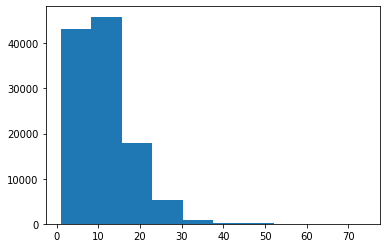

In [15]:
sentences=df["Directions"].values
len(sentences)
sentences=[s for rec in sentences  for s in sent_tokenize(rec)]
print(len(sentences))
sentences_len=list(map(lambda x:len(word_tokenize(x)), sentences))

print(sentences_len[0:10])


plt.hist(sentences_len)


In [16]:

max_len=100

sentences=sentences[:100]

dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "tags": []
    }


for sentence in tqdm(sentences):
  input_ids = []
  target_tags = []

  labels=get_label(sentence,ingredients)  
  #print(sentence)
  #print(labels)
  
  for idx, word in enumerate(word_tokenize(sentence)):
      #print(word) 
      ids = tokenizer.encode(word, add_special_tokens=False)
      #print(ids)
      input_ids.extend(ids)
      num_tokens = len(ids)
      label=label_encoder.transform([labels[idx]]).tolist()[0]
      target_tags.extend([label] * num_tokens)

  #print(target_tags)

  # Pad truncate
  input_ids = input_ids[:max_len - 2]
  target_tags = target_tags[:max_len - 2]

  input_ids = [101] + input_ids + [102]
  target_tags = [2] + target_tags + [2]
  token_type_ids = [0] * len(input_ids)
  attention_mask = [1] * len(input_ids)
  padding_len = max_len - len(input_ids)

  input_ids = input_ids + ([0] * padding_len)
  attention_mask = attention_mask + ([0] * padding_len)
  token_type_ids = token_type_ids + ([0] * padding_len)
  target_tags = target_tags + ([3] * padding_len)
        
  dataset_dict["input_ids"].append(input_ids)
  dataset_dict["token_type_ids"].append(token_type_ids)
  dataset_dict["attention_mask"].append(attention_mask)
  dataset_dict["tags"].append(target_tags)
  assert len(target_tags) == max_len, f'{len(input_ids)}, {len(target_tags)}'



for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
]
y = dataset_dict["tags"]


100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


In [19]:

loss_object=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)

def masked_ce_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 17))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)



## BERT encoder
encoder = TFBertModel.from_pretrained("bert-base-uncased")

## NER Model
input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
embedding = encoder(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
embedding = layers.Dropout(0.3)(embedding)
tag_logits = layers.Dense(4, activation='softmax')(embedding)
    
model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[tag_logits],
)
optimizer = keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=optimizer, loss=masked_ce_loss, metrics=['accuracy'])


history=model.fit(
    x,
    y,
    epochs=5,
    verbose=1,
    batch_size=12,
    validation_split=0.2
)


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
7/7 [==============================] - 18s 587ms/step - loss: 0.6445 - accuracy: 0.7793 - val_loss: 0.1485 - val_accuracy: 0.9475
Epoch 2/5
7/7 [==============================] - 1s 186ms/step - loss: 0.1121 - accuracy: 0.9689 - val_loss: 0.0502 - val_accuracy: 0.9830
Epoch 3/5
7/7 [==============================] - 1s 186ms/step - loss: 0.0508 - accuracy: 0.9841 - val_loss: 0.0420 - val_accuracy: 0.9870
Epoch 4/5
7/7 [==============================] - 1s 186ms/step - loss: 0.0400 - accuracy: 0.9886 - val_loss: 0.0337 - val_accuracy: 0.9935
Epoch 5/5
7/7 [==============================] - 1s 187ms/step - loss: 0.0328 - accuracy: 0.9904 - val_loss: 0.0301 - val_accuracy: 0.9940


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


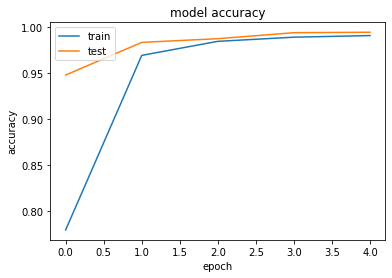

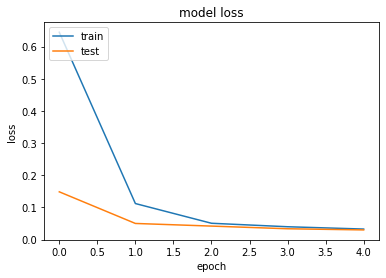

In [20]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()